# Model: Gender Only

https://www.kaggle.com/c/titanic/overview

Features included in this model are:
    
* age 
* sibsp 
* parch 
* fare


* pclass
* sex
* ticket
* embarked

The numerical features are scaled.  

In this notebook, I switched from Logistic Regression to Decision Trees. 

### References 

Decision Trees on the Titanic Data Set http://benalexkeen.com/decision-tree-classifier-in-python-using-scikit-learn/

* features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare']
* Accuracy Score = 0.83240223463687146

# Initialization

In [1]:
%run init.ipynb

In [175]:
from sklearn.impute import SimpleImputer
from sklearn.tree import (DecisionTreeClassifier, 
                          export_graphviz)

from sklearn.preprocessing import scale

import great_expectations as ge

RANDOM_STATE = 42

# Define

In [6]:

def transform_X_numerical(Xy,
                          columns=['age', 'fare', 'family_size']
                         ):

    # Scale the numerical columns.
    return pd.DataFrame(scale(Xy[columns]), index=Xy.index, columns=columns )
    

def transform_X_categorical(Xy,
                columns=['sex', 'embarked', 'title', 'age_bin', 'is_child', 'is_travelling_alone']):
    
    # Encode the categorical features. The first category will be dropped.
     return pd.get_dummies(Xy[columns], drop_first=True)
    

def transform_X(Xy,
                numerical_columns=['age', 'fare', 'family_size'],
                categorical_columns=['sex', 'embarked', 'title', 'age_bin', 'is_child', 'is_travelling_alone', 'pclass']):

    # Scale the numerical columns.
    X_numerical = transform_X_numerical(Xy, numerical_columns)
    
    # Encode the categorical features. The first category will be dropped.
    X_cat_encoded =  transform_X_categorical(Xy, categorical_columns)
    
    return X_numerical.join(X_cat_encoded)

## Extract Clean Data

In [27]:
numerical_columns=['age', 'fare', 'family_size'],
categorical_columns=['sex', 'embarked', 'title', 'age_bin', 'is_child', 'is_travelling_alone', 'pclass']

**Separate data into X (features) and y (label)**

In [231]:
Xy = pd.read_csv('../data/processed/train.csv', index_col='passengerid')
Xy.columns.tolist()

y = Xy['survived']


['survived',
 'pclass',
 'name',
 'sex',
 'sibsp',
 'parch',
 'ticket',
 'fare',
 'embarked',
 'title',
 'last_name',
 'cabin_number',
 'family_size',
 'age_estimate',
 'age',
 'age_bin',
 'is_child',
 'is_travelling_alone']

**List of Features**

In [232]:
numerical_columns=['age', 'fare', 'family_size', 'sibsp', 'parch']
categorical_columns= ['sex', 'embarked', 'title', 'age_bin', 'is_child', 'is_travelling_alone', 'pclass']

In [237]:
features = numerical_columns + categorical_columns
features

['age',
 'fare',
 'family_size',
 'sibsp',
 'parch',
 'sex',
 'embarked',
 'title',
 'age_bin',
 'is_child',
 'is_travelling_alone',
 'pclass']

## Train Test Split Data

In [239]:
X_all = transform_X(Xy, numerical_columns, categorical_columns)
X_all.columns.tolist()

['age',
 'fare',
 'family_size',
 'sibsp',
 'parch',
 'is_child',
 'is_travelling_alone',
 'pclass',
 'sex_male',
 'embarked_Q',
 'embarked_S',
 'title_Miss',
 'title_Mr',
 'title_Mrs',
 'age_bin_(10.0, 20.0]',
 'age_bin_(20.0, 30.0]',
 'age_bin_(30.0, 40.0]',
 'age_bin_(40.0, 50.0]',
 'age_bin_(50.0, 60.0]',
 'age_bin_(60.0, inf]']

In [240]:
important_features = ['title_Mr', 'title_Mrs', 'family_size', 'is_child', 'pclass']        # 11/05/19, dtree_model_1, 0.8173, 0.6486,0.8310,0.7251, NS
#important_features = ['title_Mr', 'family_size', 'is_child', 'pclass']                    # 11/05/19, Decision Tree, 0.8259, 0.6715,0.8324,0.7420, NS
#important_features =  ['age','family_size', 'is_child', 'is_travelling_alone', 'pclass',] # 11/05/19, Decision Tree, 0.6643, 0.4254,0.5792,0.4866, NS
important_features = ['title_Mr', 'family_size',  'pclass']                                # 11/05/19, dtree_model_2, 0.8272, 0.7012,0.8143,0.7516, NS

important_features = ['pclass', 'sex_male', 'age', 'sibsp', 'parch',  'fare']  # From reference

X = X_all[important_features]
X

,pclass,sex_male,age,sibsp,parch,fare
passengerid,,,,,,
1,3,1,-0.590381,0.432793,-0.473674,-0.502445
2,1,0,0.614749,0.432793,-0.473674,0.786845
3,3,0,-0.289098,-0.474545,-0.473674,-0.488854
4,1,0,0.388787,0.432793,-0.473674,0.420730
5,3,1,0.388787,-0.474545,-0.473674,-0.486337
...,...,...,...,...,...,...
887,2,1,-0.213778,-0.474545,-0.473674,-0.386671
888,1,0,-0.816343,-0.474545,-0.473674,-0.044381
889,3,0,-0.590381,0.432793,2.008933,-0.176263


### Split data into train and test. 

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
y_test = y_test.to_frame()

print(f'Number of sample in training data = {len(X_train)}')
print(f'Number of sample in test data = {len(X_test)}')

Number of sample in training data = 712
Number of sample in test data = 179


### Decision Tree Classifier

In [243]:
X.columns

model = DecisionTreeClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train) 

pm.calc_model_rst_table_metrics(model, X_train, y_train, model_name='dtree_model_2')

Index(['pclass', 'sex_male', 'age', 'sibsp', 'parch', 'fare'], dtype='object')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')


Cross Validation Scores:
	Accuracy 	: 0.7726 (+/- 0.0328)
	Recall		: 0.7018 (+/- 0.0769)
	Precision	: 0.6961 (+/- 0.0303)
	F1		: 0.6987 (+/- 0.0511)


11/05/19, dtree_model_2,  <kaggle_accuracy>, 0.7726, 0.7018,0.6961,0.6987


# Visualize the Decision Tree

In [219]:
model.tree_
feature_names=X.columns
feature_names

model.tree_

Index(['title_Mr', 'family_size', 'pclass'], dtype='object')

In [220]:
export_graphviz(model, out_file='tree.dot', feature_names=feature_names)

In [221]:
from subprocess import call

call(['dot', '-T', 'png', 'tree.dot', '-o', 'tree.png'])

0

In [225]:
X.columns.to_list()
model.feature_importances_


['title_Mr', 'family_size', 'pclass']

array([0.62400663, 0.12448485, 0.25150852])

In [223]:
model.get_params

array([0.62400663, 0.12448485, 0.25150852])

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')>

# Prepare Submission

In [198]:
X = pd.read_csv('../data/processed/holdout.csv', index_col='passengerid')

In [199]:
X_test_kaggle_public = transform_X(X).reindex(X_test.columns, axis=1).fillna(0)
X_test_kaggle_public

,title_Mr,family_size,pclass
passengerid,,,
892,1,-0.553443,3
893,0,0.105643,3
894,1,-0.553443,2
895,1,-0.553443,3
896,0,0.764728,3
...,...,...,...
1305,1,-0.553443,3
1306,0,-0.553443,1
1307,1,-0.553443,3


In [202]:
y_pred = (pd.Series(model.predict(X_test_kaggle_public), 
                   index=X.index, name='Survived').to_frame().sort_index()
         )

y_pred.index.names = ['PassengerId']

y_submission = (pd.read_csv('../data/raw/gender_submission.csv')
                .set_index('PassengerId')
               )
y_submission

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [203]:
(y_pred.index == y_submission.index).all()
y_pred.index.names == y_submission.index.names
(y_pred.columns == y_submission.columns).all()

True

True

True

In [204]:
filename = 'dtree_model_2.csv'
y_pred.to_csv(filename)

y_pred_file = (pd.read_csv(filename)
                .set_index('PassengerId')
               )

(y_pred_file.index == y_submission.index).all()
y_pred_file.index.names == y_submission.index.names
(y_pred_file.columns == y_submission.columns).all()

True

True

True

# Simplify Model

In [205]:
from yellowbrick.features import Rank1D

In [206]:
# Instantiate the 1D visualizer with the Sharpiro ranking algorithm
visualizer = Rank1D(algorithm='shapiro', size=(1000,1000))

visualizer.fit(X, y, )           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show();          # Finalize and render the figure

ValueError: could not convert string to float: 'Abbott, Master. Eugene Joseph'

<Figure size 1000x1000 with 0 Axes>

https://www.districtdatalabs.com/visualize-data-science-pipeline-with-yellowbrick

In [145]:
from cycler import cycler
import matplotlib as mpl
from yellowbrick.model_selection import FeatureImportances

FeatureImportances(absolute=True,
                   ax=<matplotlib.axes._subplots.AxesSubplot object at 0x11240f860>,
                   colormap=None, colors=None, is_fitted='auto',
                   labels=Index(['age', 'family_size', 'is_child', 'is_travelling_alone', 'pclass'], dtype='object'),
                   model=None, relative=False, stack=False, xlabel=None)

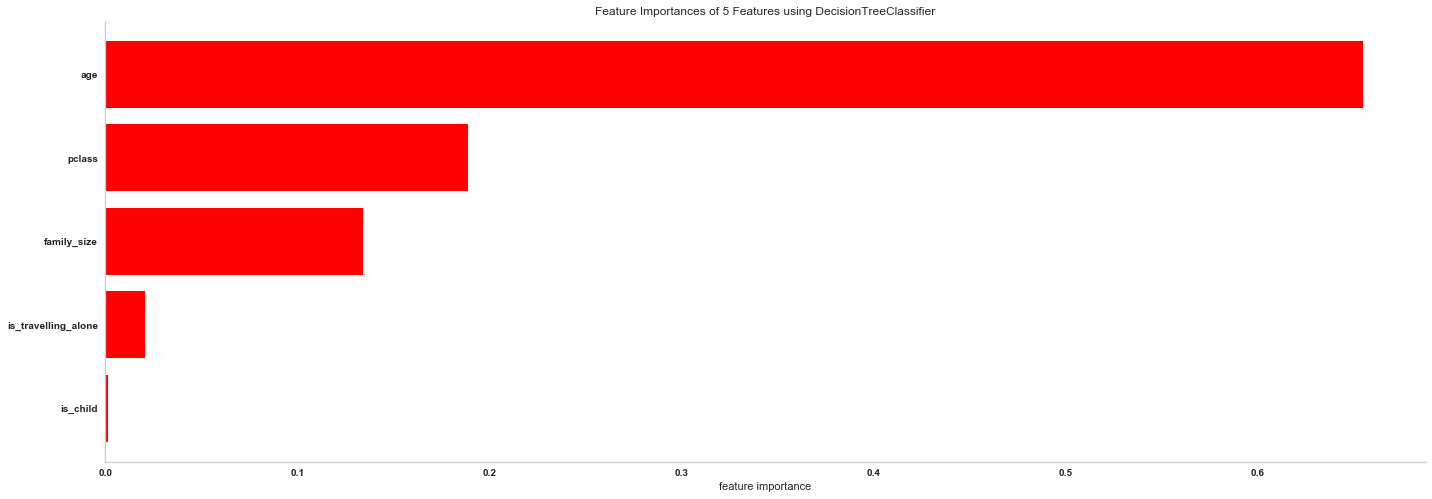

In [146]:
# Create a new figure
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['red'])
fig = plt.gcf()
fig.set_size_inches(20,20)
ax = plt.subplot(311)
labels = X.columns

viz = FeatureImportances(model, ax=ax, labels=labels, relative=False, absolute=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

# Fit and display
viz.fit(X, y)
viz.poof()

17